In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from math import pi
from itertools import product
import sys

# sys.stderr = open(snakemake.log[0], "w")
from sklearn import linear_model
from typing import List, Tuple
from scipy import stats
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.scale import scale_factory

In [2]:
plt.style.use("ggplot")
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:


DELIM = ","
PAIR_IDX = ("sample1", "sample2")
BLACK = "#4c566a"
BLUE = ggplot_cm[1]
PURPLE = ggplot_cm[2]
YELLOW = ggplot_cm[4]
RED = ggplot_cm[0]
XCOL = "COMPASS_dist"
YCOL = "ont_dist"


def robust_regression(x: List[float], y: List[float]) -> List[float]:
    """Returns the prediction of the model. This prediction is used with X to plot
    line of best fit and get equation for that line.
    """
    X = [[v] for v in x]
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    pred = ransac.predict(X)
    return pred


def fit_model(
        x: List[float], y_pred: List[float]
) -> Tuple[float, float, float, float, float]:
    """Returns: gradient, intercept, r_value, p_value, std_err"""
    return stats.linregress(x, y_pred)


class AsymmetrixMatrixError(Exception):
    pass


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


# load the data
compass_df = load_matrix("compass.matrix.csv", name=XCOL)
ont_df = load_matrix("bcftools.matrix.csv", name=YCOL)
# merge the matrices
data = pd.concat([compass_df, ont_df], axis=1)
data = data.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)



# Close dotplot

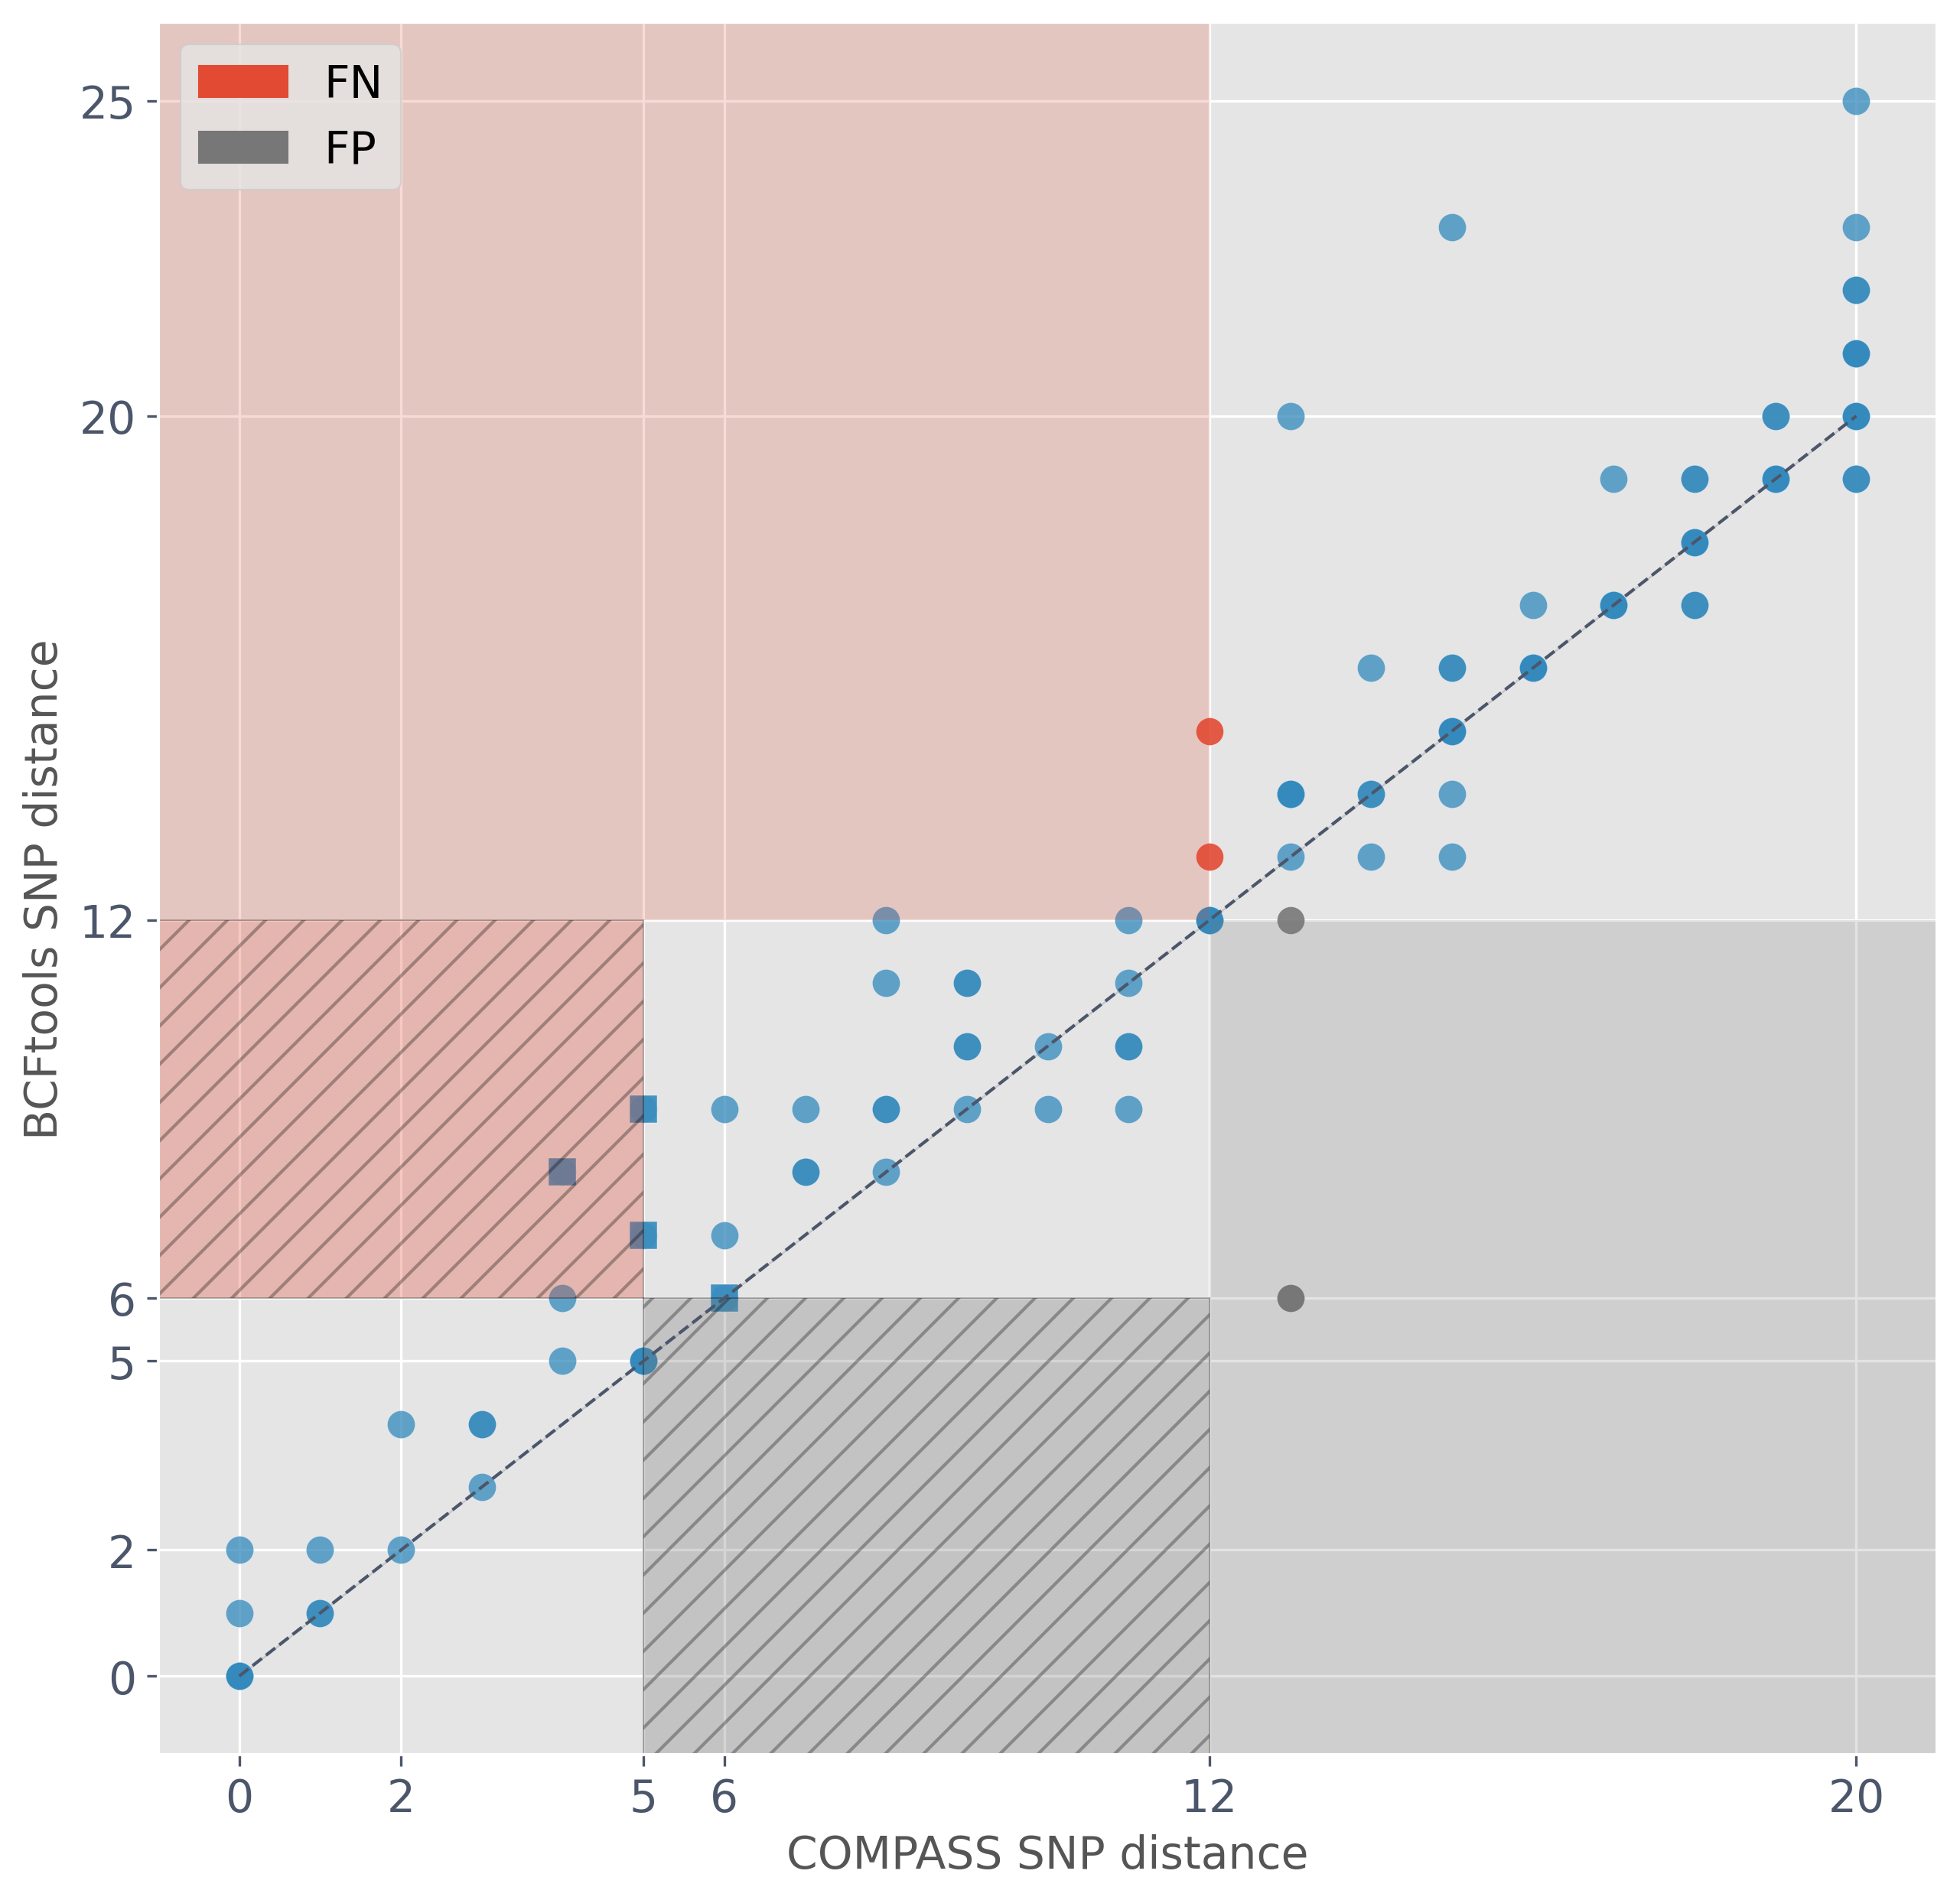

In [3]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=0.8, linewidth=0.5, s=75)

xs = data[XCOL]

ax.set_xlabel("COMPASS SNP distance", fontsize=14)
ax.set_ylabel("BCFtools SNP distance", fontsize=14)
# ax.legend(loc="lower right", prop=dict(size=12))

# set the lower left corner of the zoom inset (x0, y0, width, height)
# axins = ax.inset_axes(bounds=[0.05, 0.52, 0.5, 0.48])
# sub region of the original image
threshold = 20
inset_data = data.query(f"{XCOL} <= @threshold")


xs = inset_data[XCOL]

# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--", linewidth=1)

# set the inset axis limits
ax.set_xlim(auto=True)
ax.set_ylim(auto=True)

ax.tick_params(color=BLACK, labelcolor=BLACK)

# add threshold-based partitions
illumina_t = 12
nanopore_t = 12
lower_xt = 5
lower_yt = 6

kwargs = dict(alpha=0.9, linewidth=0.1, s=75)
# partition data into the quadrants
ont_fns = inset_data.query(f"{YCOL}>@nanopore_t and {XCOL}<=@illumina_t")
ont_fps = inset_data.query(f"{YCOL}<=@nanopore_t and {XCOL}>@illumina_t")
good_data = inset_data[~inset_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
ax = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=ax, color=BLUE, alpha=0.5, linewidth=0.1, s=75)
ax = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=ax, color=RED, **kwargs)
ax = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=ax, color=ggplot_cm[3], **kwargs)

# https://stackoverflow.com/questions/46961465/different-background-colour-areas-on-matplotlib-plot
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.axhspan(ymin=nanopore_t, ymax=ymax, xmin=0, xmax=((illumina_t-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.2)
ax.axvspan(xmin=illumina_t, xmax=xmax, ymin=0, ymax=((nanopore_t-ymin)/(ymax-ymin)), facecolor=ggplot_cm[3], alpha=0.2)
ax.set(ylim=(ymin, ymax), xlim=(xmin, xmax))

inset_ticklabels = [0, 2, 5, 6, 12, threshold]
inset_fs = 14
ax.set_xticks(inset_ticklabels)
ax.set_xticklabels(inset_ticklabels, fontsize=inset_fs)
inset_ticklabels.append(inset_data.max()[YCOL])
ax.set_yticks(inset_ticklabels)
ax.set_yticklabels(inset_ticklabels, fontsize=inset_fs)

ax.axhspan(ymin=lower_yt, ymax=nanopore_t, xmin=0, xmax=((lower_xt-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.3, hatch="//", edgecolor="black")
ax.axvspan(xmin=lower_xt, xmax=illumina_t, ymin=0, ymax=((lower_yt-ymin)/(ymax-ymin)), facecolor=ggplot_cm[3], alpha=0.3, hatch="//", edgecolor="black")
ont_fns = good_data.query(f"{YCOL}>@lower_yt and {XCOL}<=@lower_xt")
ont_fps = good_data.query(f"{YCOL}<=@lower_yt and {XCOL}>@lower_xt")
good_data = good_data[~good_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
ax = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=ax, color=BLUE, alpha=0.5, linewidth=0.1, s=75)
ax = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=ax, color=BLUE, marker="s", **kwargs)
ax = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=ax, color=BLUE, marker="s", **kwargs)

red_patch = mpatches.Patch(color=RED, label="FN")
black_patch = mpatches.Patch(color=ggplot_cm[3], label="FP")
ax.legend(handles=[red_patch, black_patch], loc="upper left", prop=dict(size=14))
# fig.savefig("/Users/michaelhall/Projects/head_to_head_pipeline/docs/paper_figures/fig3.png")

# Full dotplot

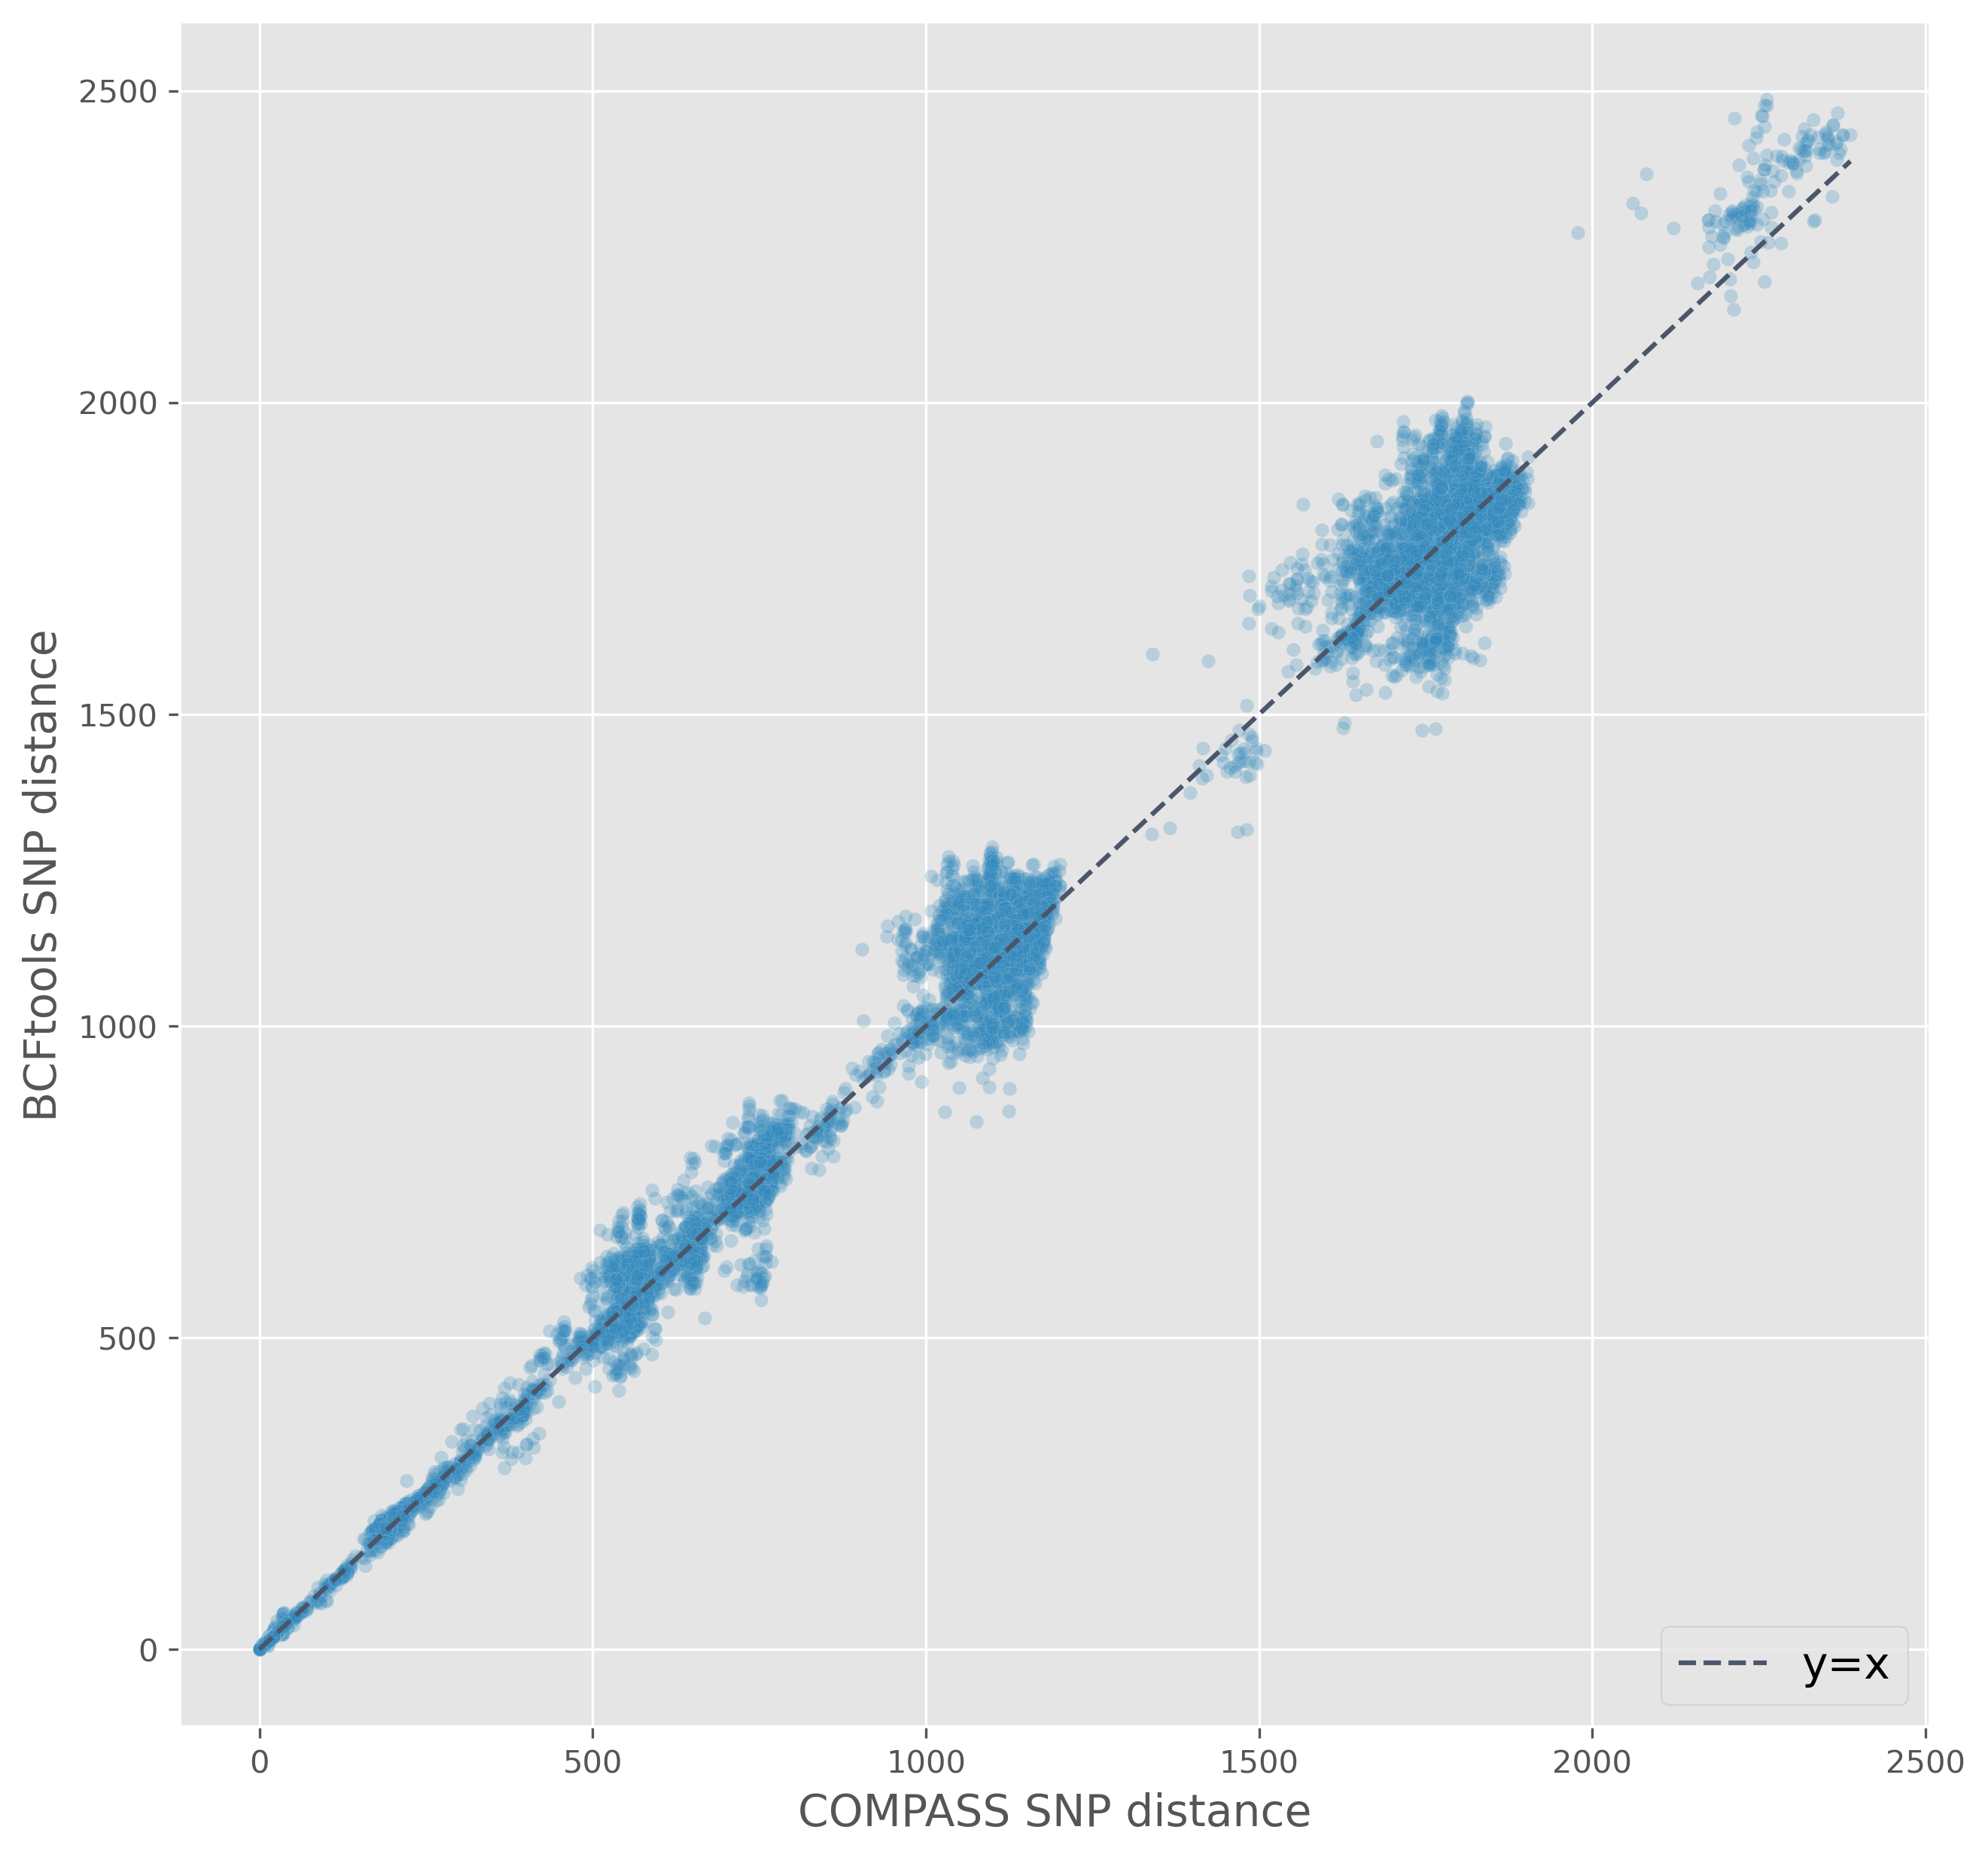

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=0.25, linewidth=0.1)
sns.scatterplot(data=data, x=XCOL, y=YCOL, color=BLUE, ax=ax, **kwargs, s=20)

xs = data[XCOL]

# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance", fontsize=14)
ax.set_ylabel("BCFtools SNP distance", fontsize=14)
ax.legend(loc="lower right", prop=dict(size=14))

In [5]:
samplesheet = pd.read_csv("../../../docs/samples.paper.csv", index_col="sample")

In [6]:
lineage_dists = []
for i, row in data.iterrows():
    s1 = row.sample1
    s2 = row.sample2
    s1_lin = samplesheet.at[s1, "lineage"][0]
    s2_lin = samplesheet.at[s2, "lineage"][0]
    lineage_dists.append((s1_lin, s2_lin, row.COMPASS_dist, "illumina"))
    lineage_dists.append((s2_lin, s1_lin, row.COMPASS_dist, "illumina"))
    lineage_dists.append((s1_lin, s2_lin, row.ont_dist, "nanopore"))
    lineage_dists.append((s2_lin, s1_lin, row.ont_dist, "nanopore"))

In [7]:
lindf = pd.DataFrame(lineage_dists, columns=["lineage1", "lineage2", "distance", "technology"])

In [8]:
lindf

lineage1 lineage2  distance technology
0            4        4         1   illumina
1            4        4         1   illumina
2            4        4         1   nanopore
3            4        4         1   nanopore
4            4        2      1089   illumina
...        ...      ...       ...        ...
45295        4        1      1747   nanopore
45296        4        4       203   illumina
45297        4        4       203   illumina
45298        4        4       219   nanopore
45299        4        4       219   nanopore

[45300 rows x 4 columns]

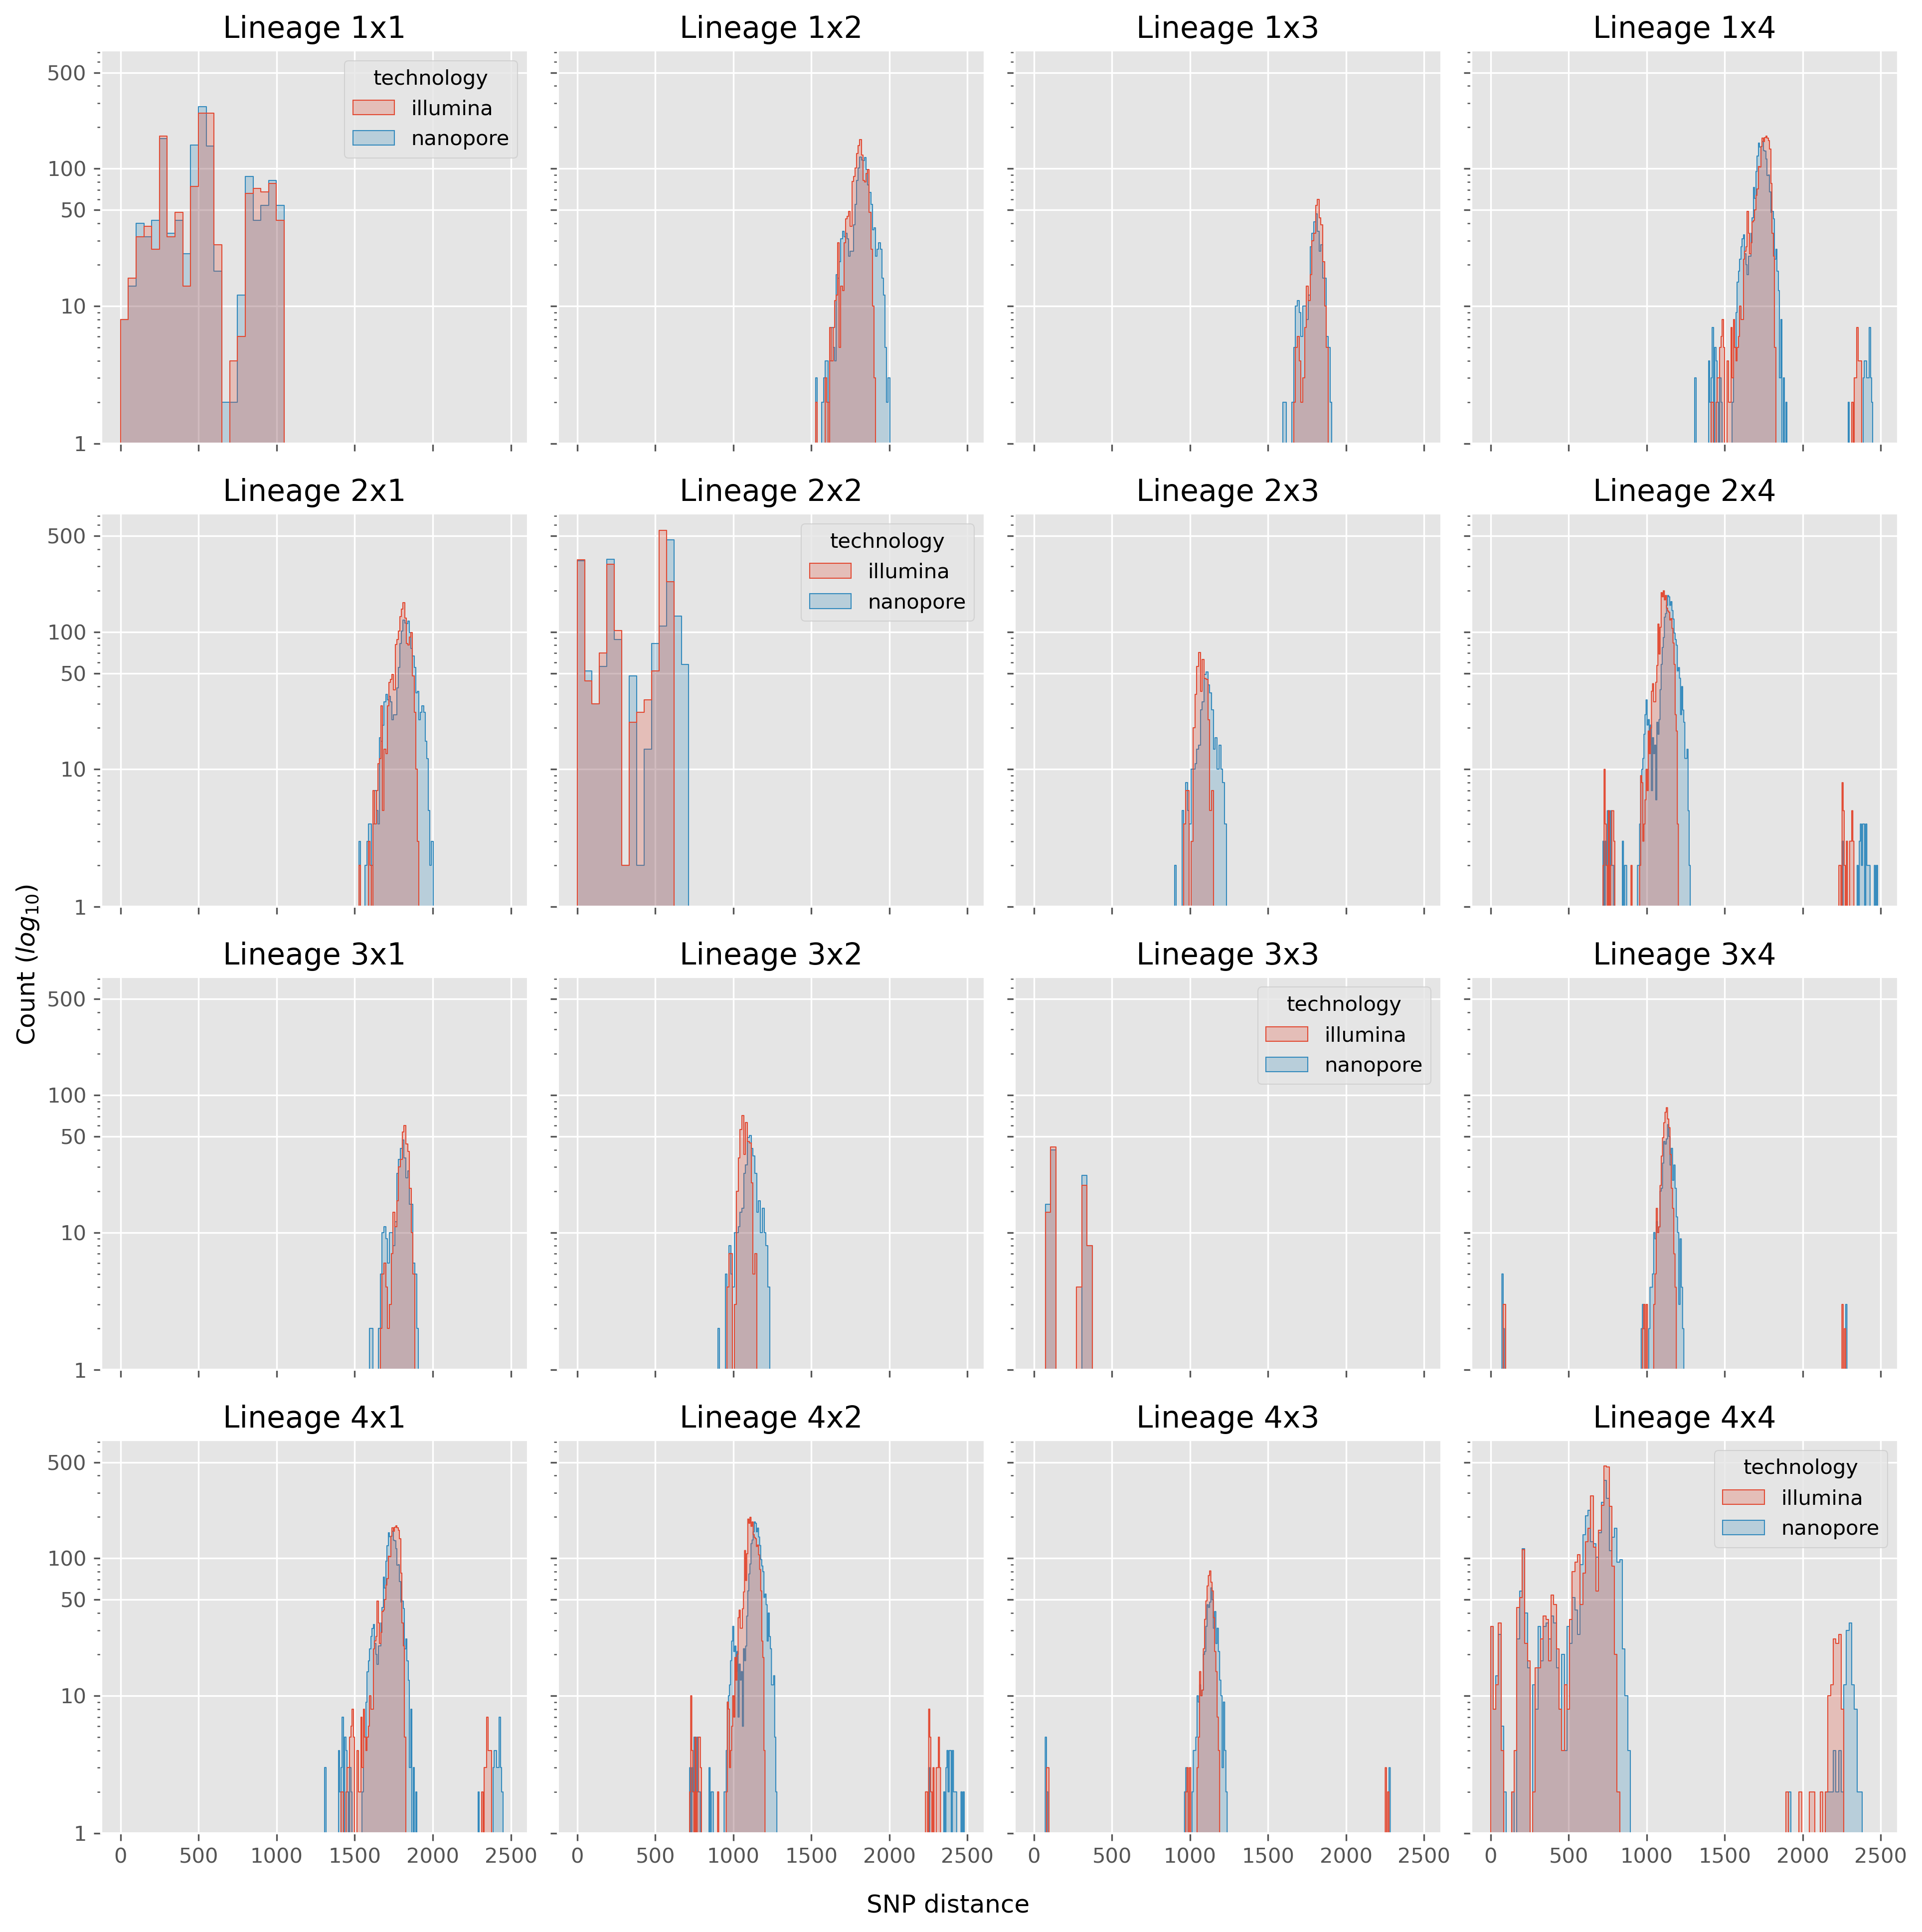

In [9]:
x="technology" 
y="distance" 
rows = sorted(set(lindf["lineage1"])) 
cols = sorted(set(lindf["lineage2"])) 
fig, axes = plt.subplots(figsize=(13, 13), dpi=300, nrows=len(rows), ncols=len(cols), sharey=True, sharex=True)
ylabs = [1, 10, 100, 500, 1000, 1500, 2000, 2500]

for ax, (l1, l2) in zip(axes.flatten(), product(rows, cols)):
    data = lindf.query("lineage1==@l1 and lineage2==@l2")
#     sns.violinplot(data=data, x=x, y=y, ax=ax, )#showfliers=False, capsize=1)
#     sns.boxenplot(data=data, x=x, y=y, ax=ax, showfliers=False)
#     sns.stripplot(data=data, x=x, y=y, ax=ax, alpha=0.1, color="black")
    sns.histplot(data=data, x=y, hue=x, ax=ax, element="step")#, alpha=0.1, color="black")
    ax.set(xlabel="", ylabel="", title=f"Lineage {l1}x{l2}")
    ax.set_yscale("log")
    ylabs = [1, 10, 50, 100, 500]
    ax.set(yticks=ylabs, yticklabels=ylabs)
    if l1 != l2:
        ax.get_legend().remove()

fig.supylabel('Count ($log_{10}$)')
fig.supxlabel('SNP distance')
fig.tight_layout()

In [10]:
ax

<AxesSubplot:title={'center':'Lineage 4x4'}>

# Combined dotplot

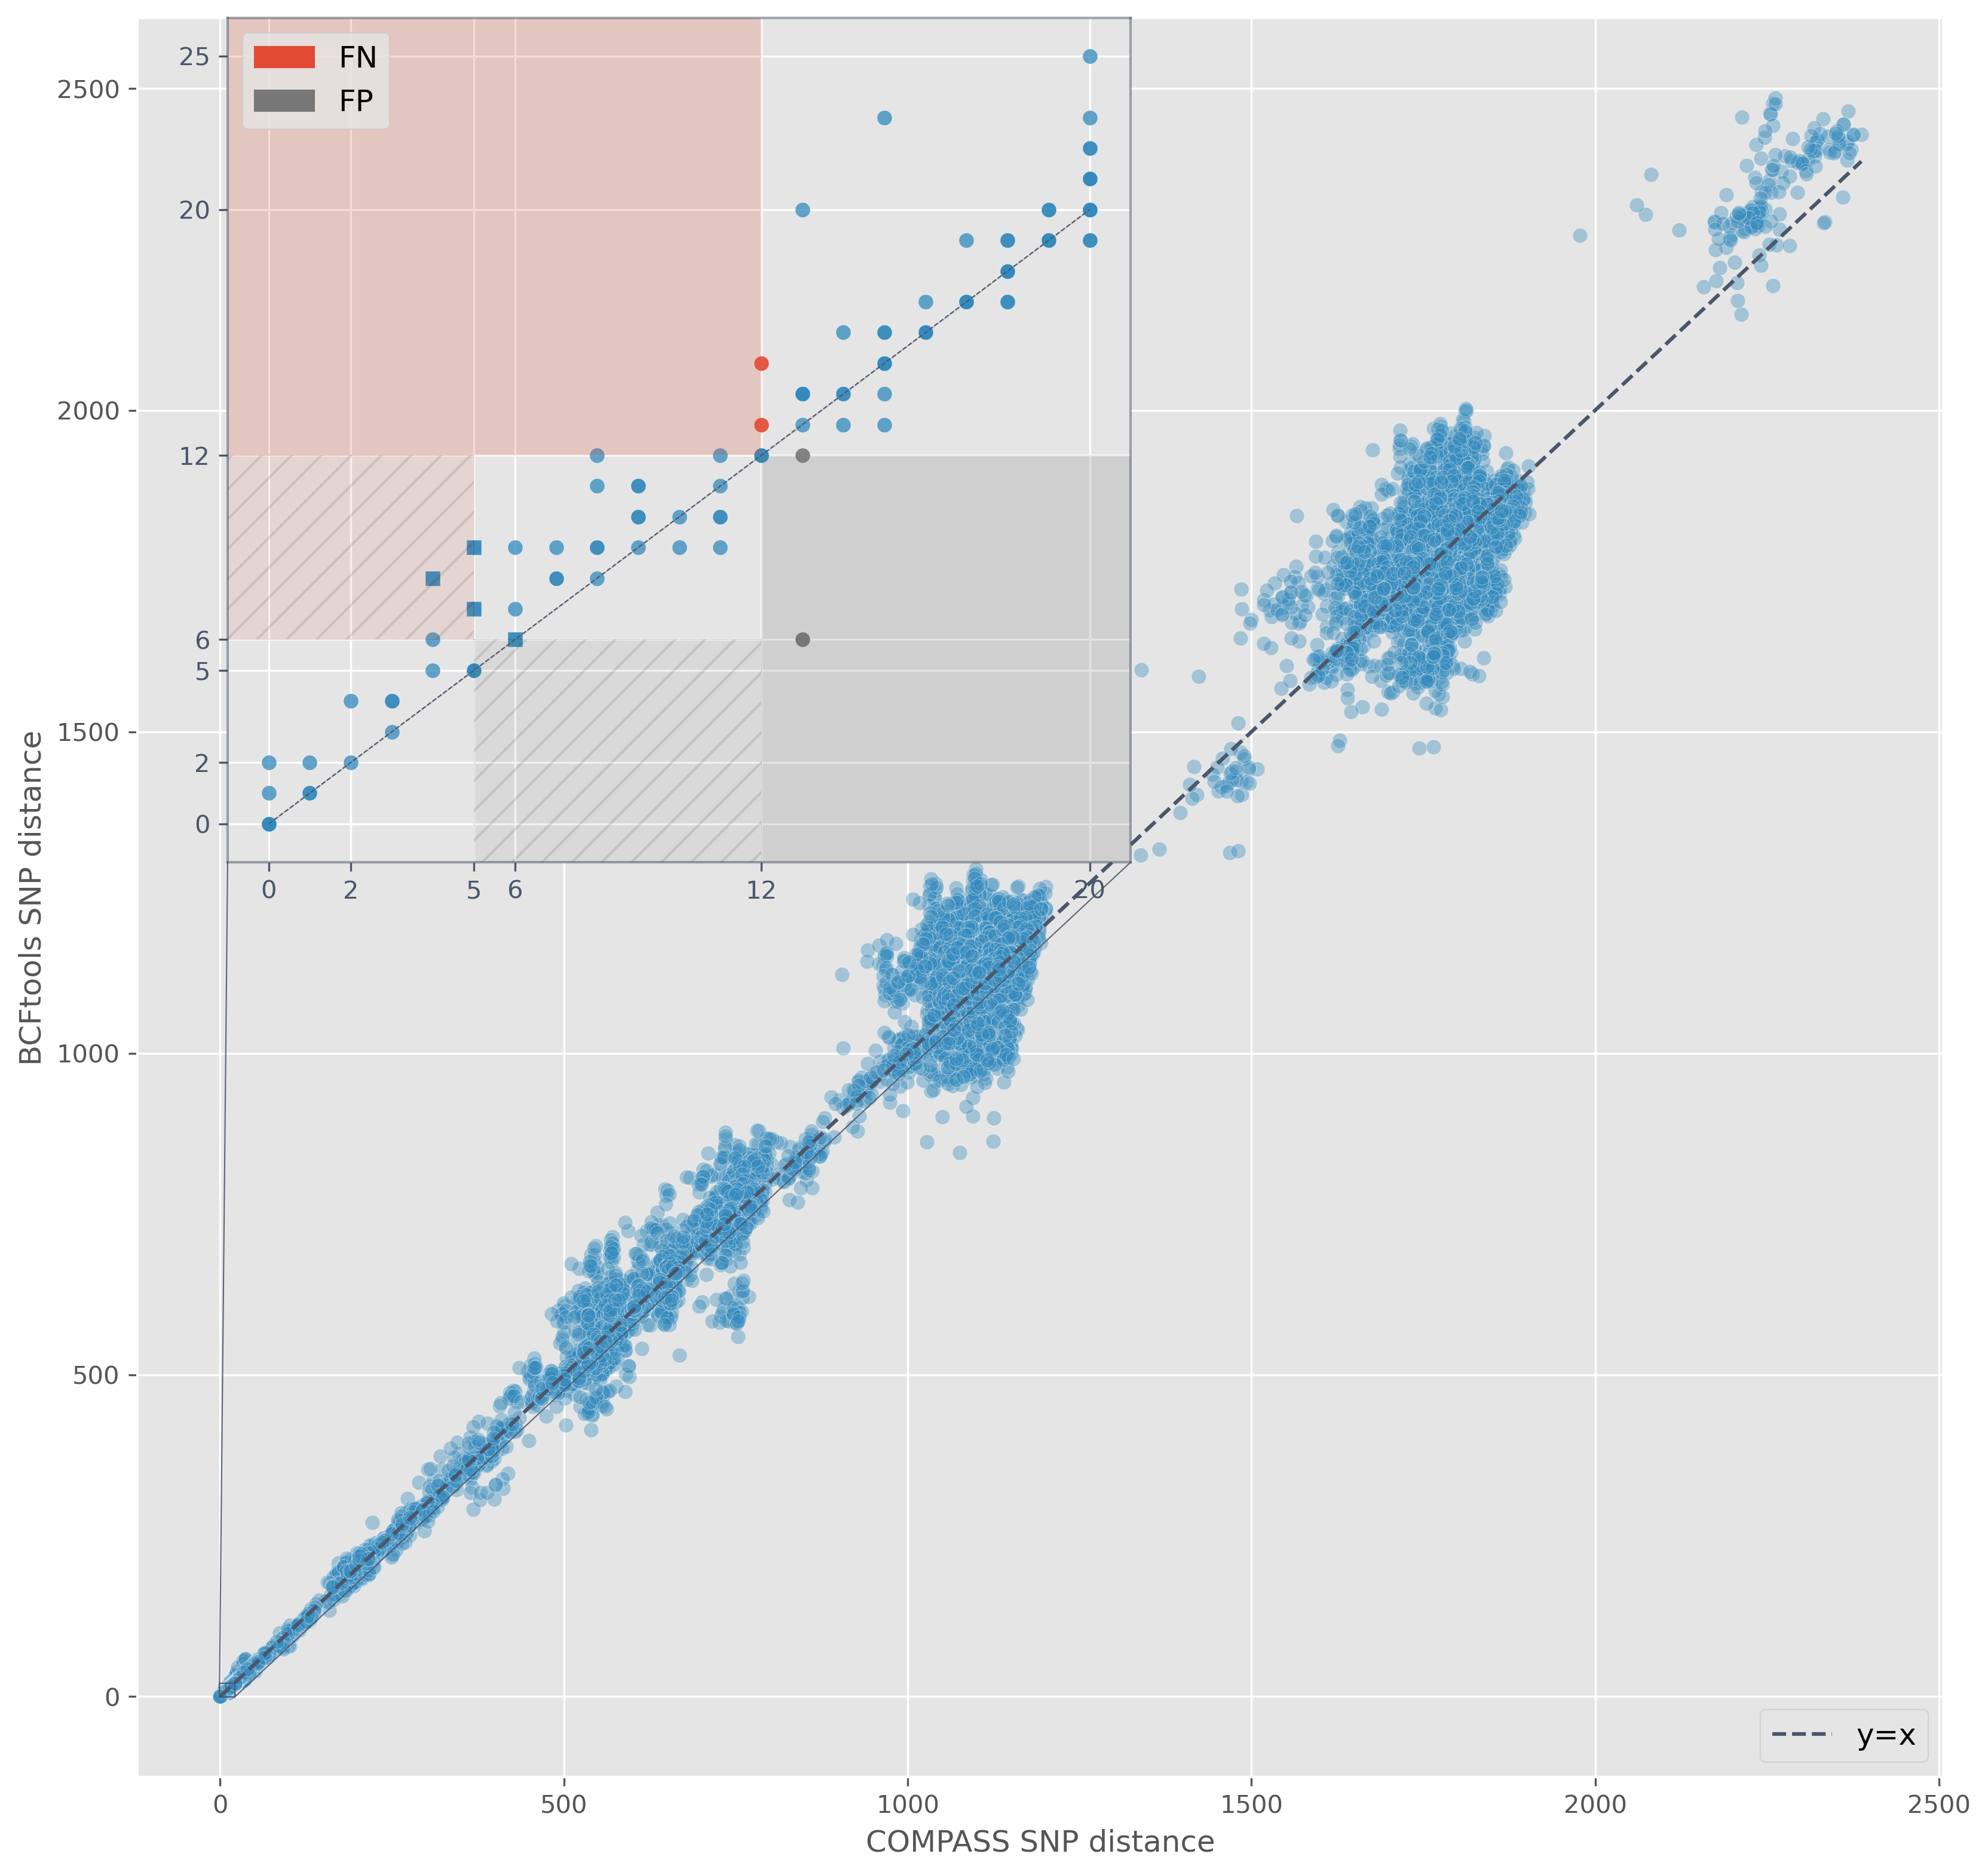

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=0.75, linewidth=0.25)
sns.scatterplot(data=data, x=XCOL, y=YCOL, color=BLUE, ax=ax, **kwargs)

# fit robust linear regression
xs = data[XCOL]
# ys = data[YCOL]
# y_pred = robust_regression(xs, ys)
# slope, intercept, *_ = fit_model(xs, y_pred)
# equation = f"y={slope:.3f}x+{intercept:.3f}"

# plot line of best fit as defined by the model
# sns.lineplot(x=xs, y=y_pred, ax=ax, label=equation, color=BLUE)
# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance", fontsize=12)
ax.set_ylabel("BCFtools SNP distance", fontsize=12)
ax.legend(loc="lower right", prop=dict(size=12))

# set the lower left corner of the zoom inset (x0, y0, width, height)
axins = ax.inset_axes(bounds=[0.05, 0.52, 0.5, 0.48])
# sub region of the original image
threshold = 20
inset_data = data.query(f"{XCOL} <= @threshold")

kwargs["alpha"] *= 2


# plot line of best fit as defined by the model
xs = inset_data[XCOL]
# ys = inset_data[YCOL]
# y_pred = robust_regression(xs, ys)
# slope, intercept, *_ = fit_model(xs, y_pred)
# equation = f"y={slope:.3f}x+{intercept:.3f}"

# plot line of best fit as defined by the model
# sns.lineplot(x=xs, y=y_pred, ax=axins, label=equation, color=BLUE)

# plot identity line
sns.lineplot(x=xs, y=xs, ax=axins, label="y=x", color=BLACK, linestyle="--", linewidth=0.5)

# set the inset axis limits
axins.set_xlim(auto=True)
axins.set_ylim(auto=True)

# styling of the inset zoom lines
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins, alpha=0.9, edgecolor=BLACK)

# explicitly make the lines for the zoom window connector from the lower-left and -right corners
for i in range(len(connector_lines)):
    if i % 2 == 0:  # lower-left and lower-right
        connector_lines[i].set_visible(True)
    else:
        connector_lines[i].set_visible(False)

axins.tick_params(color=BLACK, labelcolor=BLACK)
# add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor(BLACK)
    spine.set_alpha(0.5)

axins.legend(loc="lower right")

# add threshold-based partitions
illumina_t = 12
nanopore_t = 12
lower_xt = 5
lower_yt = 6
# axins.axhline(y=nanopore_t, color="black", linestyle="--", alpha=0.25)
# axins.axvline(x=illumina_t, color="black", linestyle="--", alpha=0.25)

kwargs = dict(alpha=0.9, linewidth=0.1)
# partition data into the quadrants
ont_fns = inset_data.query(f"{YCOL}>@nanopore_t and {XCOL}<=@illumina_t")
ont_fps = inset_data.query(f"{YCOL}<=@nanopore_t and {XCOL}>@illumina_t")
good_data = inset_data[~inset_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
axins = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=axins, color=BLUE, alpha=0.5, linewidth=0.1)
axins = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=axins, color=RED, **kwargs)
axins = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=axins, color=ggplot_cm[3], **kwargs)

# https://stackoverflow.com/questions/46961465/different-background-colour-areas-on-matplotlib-plot
ymin, ymax = axins.get_ylim()
xmin, xmax = axins.get_xlim()
axins.axhspan(ymin=nanopore_t, ymax=ymax, xmin=0, xmax=((illumina_t-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.2)
axins.axvspan(xmin=illumina_t, xmax=xmax, ymin=0, ymax=((nanopore_t-ymin)/(ymax-ymin)), facecolor=ggplot_cm[3], alpha=0.2)
# fig.savefig(snakemake.output.plot)
axins.set(ylim=(ymin, ymax), xlim=(xmin, xmax))

inset_ticklabels = [0, 2, 5, 6, 12, threshold]
inset_fs = 10
axins.set_xticks(inset_ticklabels)
axins.set_xticklabels(inset_ticklabels, fontsize=inset_fs)
inset_ticklabels.append(inset_data.max()[YCOL])
axins.set_yticks(inset_ticklabels)
axins.set_yticklabels(inset_ticklabels, fontsize=inset_fs)


axins.axhspan(ymin=lower_yt, ymax=nanopore_t, xmin=0, xmax=((lower_xt-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.1, hatch="//", edgecolor="black")
axins.axvspan(xmin=lower_xt, xmax=illumina_t, ymin=0, ymax=((lower_yt-ymin)/(ymax-ymin)), facecolor=ggplot_cm[3], alpha=0.1, hatch="//", edgecolor="black")
ont_fns = good_data.query(f"{YCOL}>@lower_yt and {XCOL}<=@lower_xt")
ont_fps = good_data.query(f"{YCOL}<=@lower_yt and {XCOL}>@lower_xt")
good_data = good_data[~good_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
axins = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=axins, color=BLUE, alpha=0.5, linewidth=0.1)
axins = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=axins, color=BLUE, marker="s", **kwargs)
axins = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=axins, color=BLUE, marker="s", **kwargs)

# remove axis labels on inset
axins.set_xlabel("")
axins.set_ylabel("")

red_patch = mpatches.Patch(color=RED, label="FN")
black_patch = mpatches.Patch(color=ggplot_cm[3], label="FP")
axins.legend(handles=[red_patch, black_patch], loc="upper left", prop=dict(size=12))

# Mixed dist

In [6]:
def load_mixed_matrix(fpath: str, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    m = np.array(matrix)[idx]

    df = pd.DataFrame(m, columns=sorted_names, index=sorted_names)
    df = df.stack().rename(name).astype(int)
    df = df.rename_axis(PAIR_IDX)
    # remove the diagonal of the matrix
    ix = [x != y for (x, y) in df.index]
    df = df[ix]
    return df

In [7]:
# load the data
compass_df = load_mixed_matrix("compass.matrix.csv", name=XCOL)
ont_df = load_mixed_matrix("mixed.matrix.csv", name=YCOL)
# merge the matrices
data = pd.concat([compass_df, ont_df], axis=1)
data = data.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)



In [10]:
ALPHA = 0.25
LW = 0.1
FS = 14

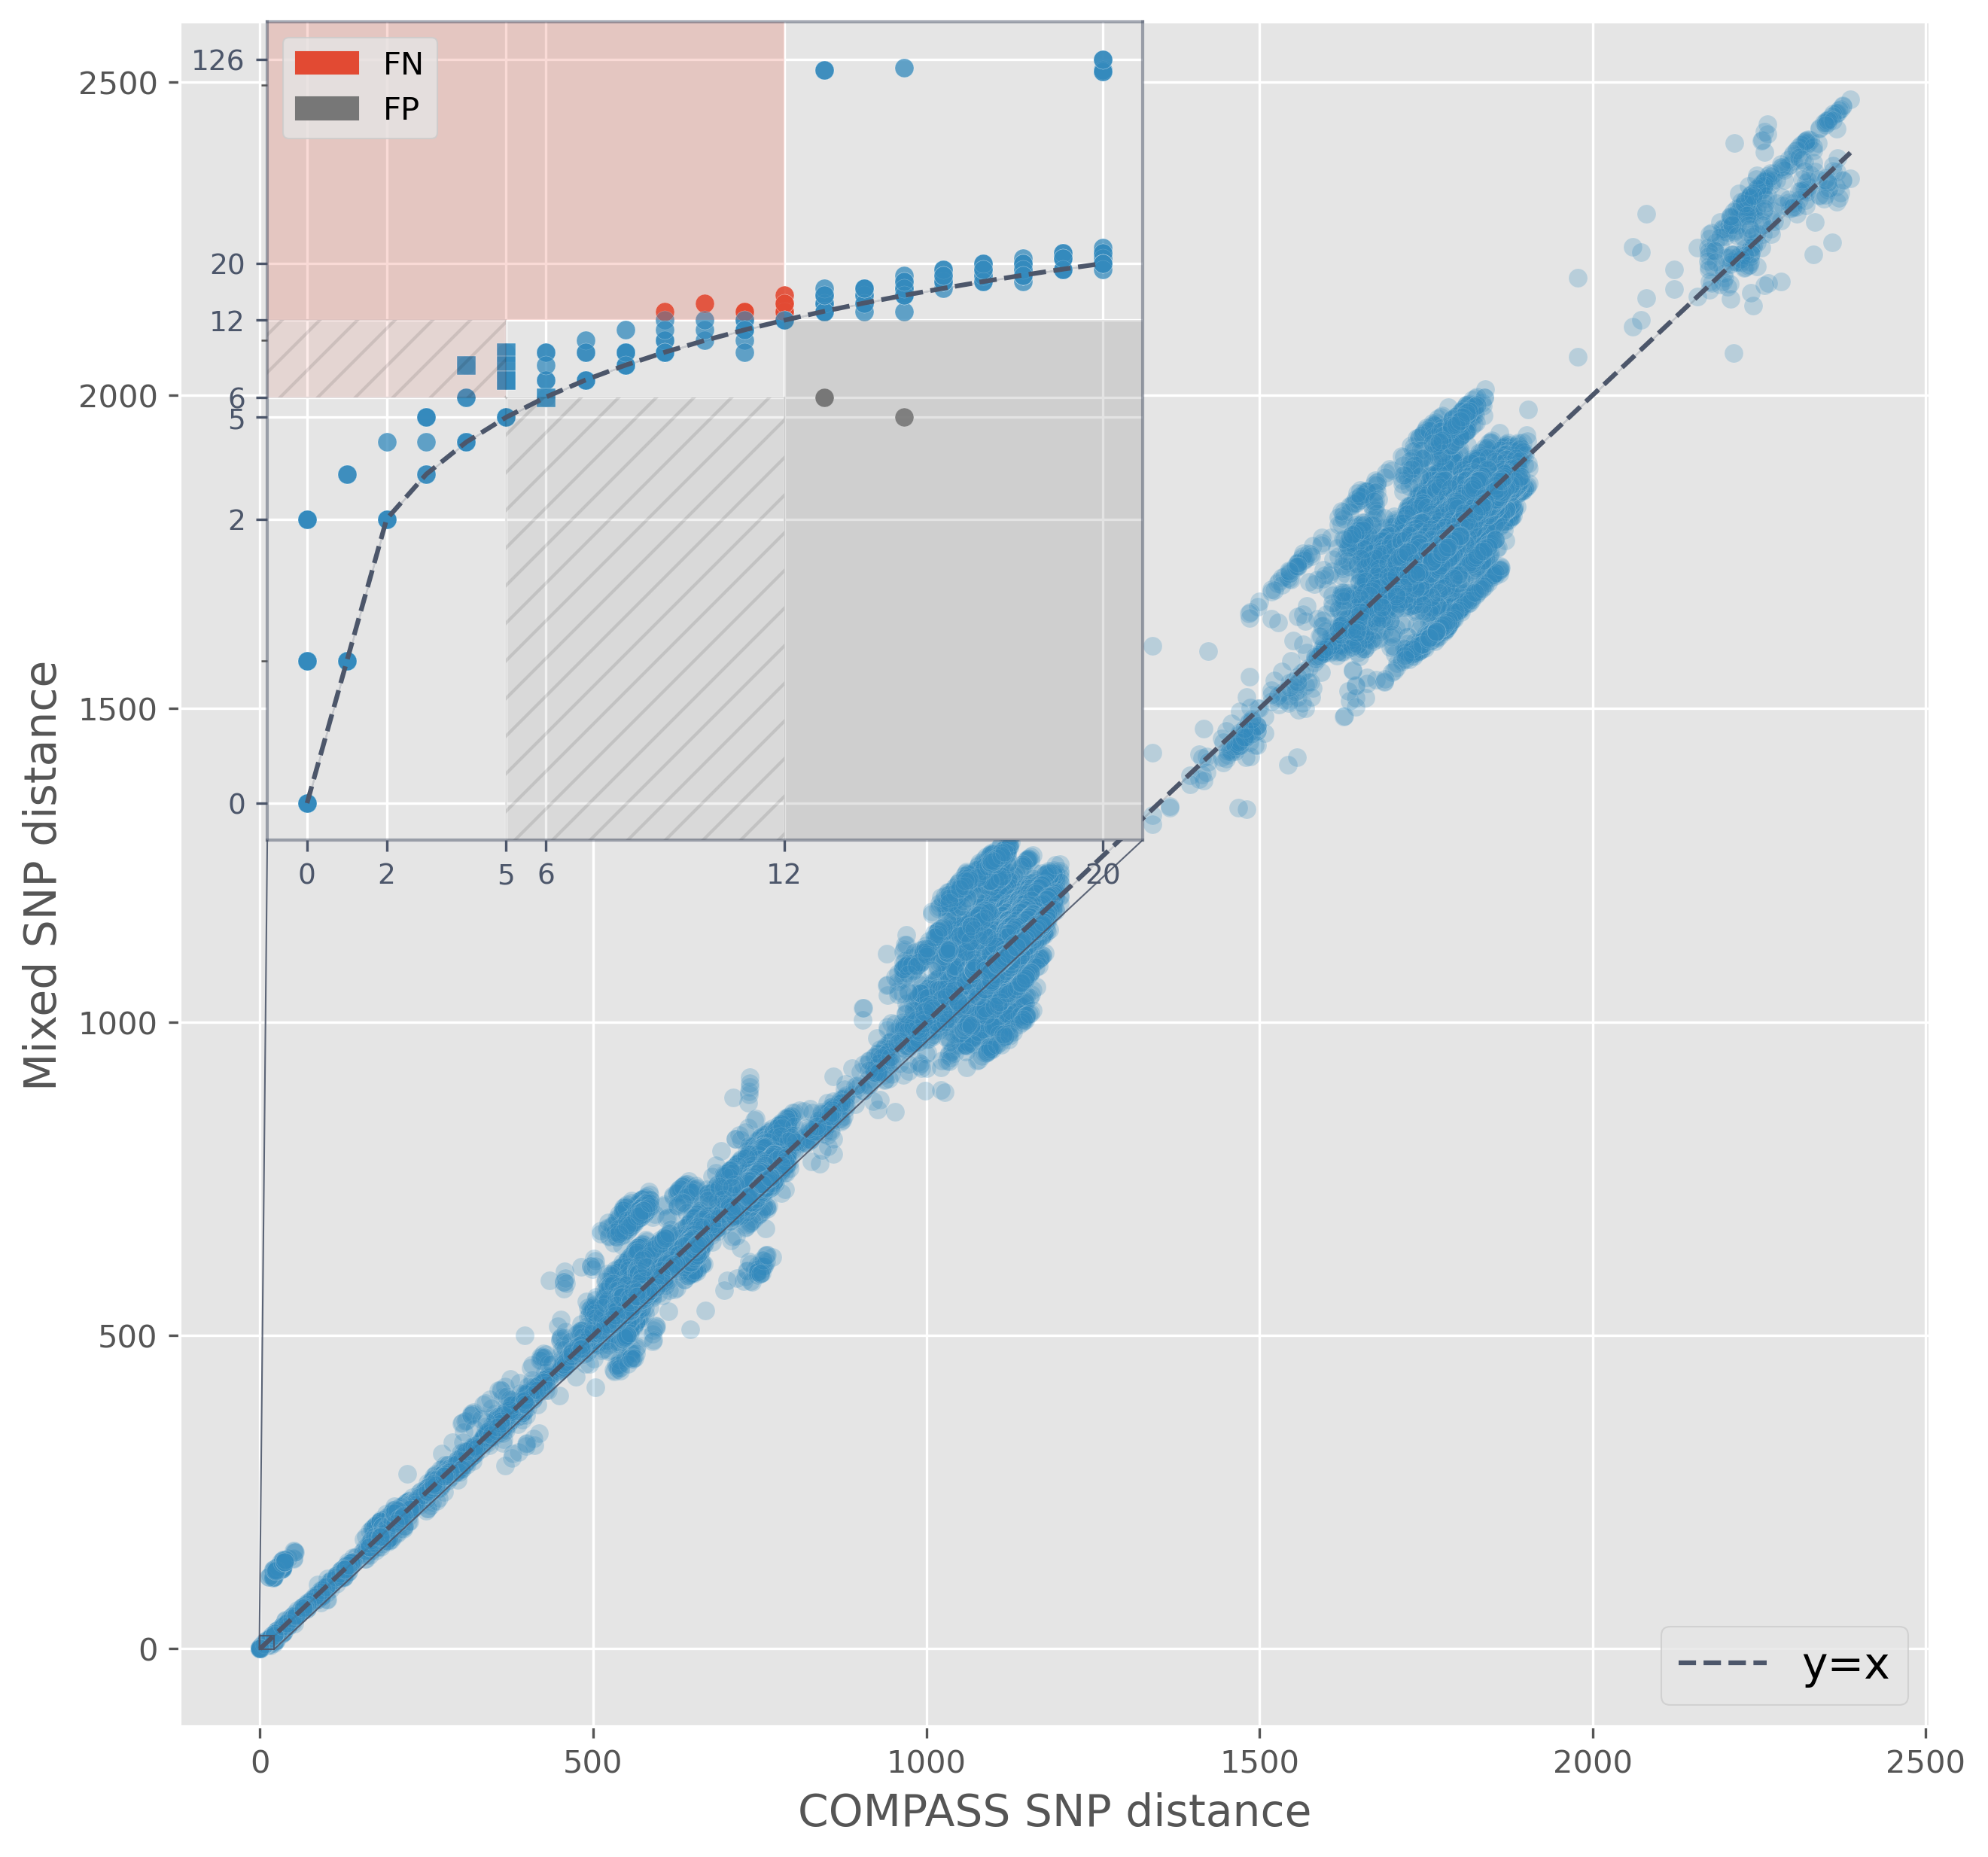

In [20]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=ALPHA, linewidth=LW)
sns.scatterplot(data=data, x=XCOL, y=YCOL, color=BLUE, ax=ax, **kwargs)

xs = data[XCOL]

# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance", fontsize=FS)
ax.set_ylabel("Mixed SNP distance", fontsize=FS)
ax.legend(loc="lower right", prop=dict(size=FS))

# set the lower left corner of the zoom inset (x0, y0, width, height)
axins = ax.inset_axes(bounds=[0.05, 0.52, 0.5, 0.48])
# sub region of the original image
threshold = 20
inset_data = data.query(f"{XCOL} <= @threshold")

kwargs["alpha"] *= 2

xs = inset_data[XCOL]

# plot identity line
sns.lineplot(x=xs, y=xs, ax=axins, label="y=x", color=BLACK, linestyle="--")

# set the inset axis limits
axins.set_xlim(auto=True)
axins.set_ylim(auto=True)
axins.set_yscale("symlog")

symlog = scale_factory("symlog", axins).get_transform().transform

# styling of the inset zoom lines
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins, alpha=0.9, edgecolor=BLACK)

# explicitly make the lines for the zoom window connector from the lower-left and -right corners
for i in range(len(connector_lines)):
    if i % 2 == 0:  # lower-left and lower-right
        connector_lines[i].set_visible(True)
    else:
        connector_lines[i].set_visible(False)

axins.tick_params(color=BLACK, labelcolor=BLACK)
# add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor(BLACK)
    spine.set_alpha(0.5)



# add threshold-based partitions
illumina_t = 12
nanopore_t = 12
lower_xt = 5
lower_yt = 6

kwargs = dict(alpha=0.9, linewidth=0.1)
# partition data into the quadrants
ont_fns = inset_data.query(f"{YCOL}>@nanopore_t and {XCOL}<=@illumina_t")
ont_fps = inset_data.query(f"{YCOL}<=@nanopore_t and {XCOL}>@illumina_t")
good_data = inset_data[~inset_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
axins = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=axins, color=BLUE, alpha=0.5, linewidth=0.1)
axins = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=axins, color=RED, **kwargs)
axins = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=axins, color=ggplot_cm[3], **kwargs)

# https://stackoverflow.com/questions/46961465/different-background-colour-areas-on-matplotlib-plot
ymin, ymax = axins.get_ylim()
xmin, xmax = axins.get_xlim()
axins.axhspan(ymin=nanopore_t, ymax=ymax, xmin=0, xmax=((illumina_t-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.2)
axins.axvspan(xmin=illumina_t, xmax=xmax, ymin=0, ymax=((symlog(nanopore_t)-symlog(ymin))/(symlog(ymax)-symlog(ymin))), facecolor=ggplot_cm[3], alpha=0.2)
# fig.savefig(snakemake.output.plot)
axins.set(ylim=(ymin, ymax), xlim=(xmin, xmax))

inset_ticklabels = [0, 2, 5, 6, 12, threshold]
inset_fs = FS-5
axins.set_xticks(inset_ticklabels)
axins.set_xticklabels(inset_ticklabels, fontsize=inset_fs)
inset_ticklabels.append(inset_data.max()[YCOL])
axins.set_yticks(inset_ticklabels)
axins.set_yticklabels(inset_ticklabels, fontsize=inset_fs)

axins.axhspan(ymin=lower_yt, ymax=nanopore_t, xmin=0, xmax=((lower_xt-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.1, hatch="//", edgecolor="black")
axins.axvspan(xmin=lower_xt, xmax=illumina_t, ymin=0, ymax=((symlog(lower_yt)-symlog(ymin))/(symlog(ymax)-symlog(ymin))), facecolor=ggplot_cm[3], alpha=0.1, hatch="//", edgecolor="black")
ont_fns = good_data.query(f"{YCOL}>@lower_yt and {XCOL}<=@lower_xt")
ont_fps = good_data.query(f"{YCOL}<=@lower_yt and {XCOL}>@lower_xt")
good_data = good_data[~good_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
axins = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=axins, color=BLUE, alpha=0.5, linewidth=0.1)
axins = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=axins, color=BLUE, marker="s", **kwargs)
axins = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=axins, color=BLUE, marker="s", **kwargs)

# remove axis labels on inset
axins.set_xlabel("")
axins.set_ylabel("")


red_patch = mpatches.Patch(color=RED, label="FN")
black_patch = mpatches.Patch(color=ggplot_cm[3], label="FP")
axins.legend(handles=[red_patch, black_patch], loc="upper left", prop=dict(size=FS-4))

                0
count  151.000000
mean     0.748344
std      1.327748
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max     10.000000
Largest outlier is mada_102 with a self-distance of 10


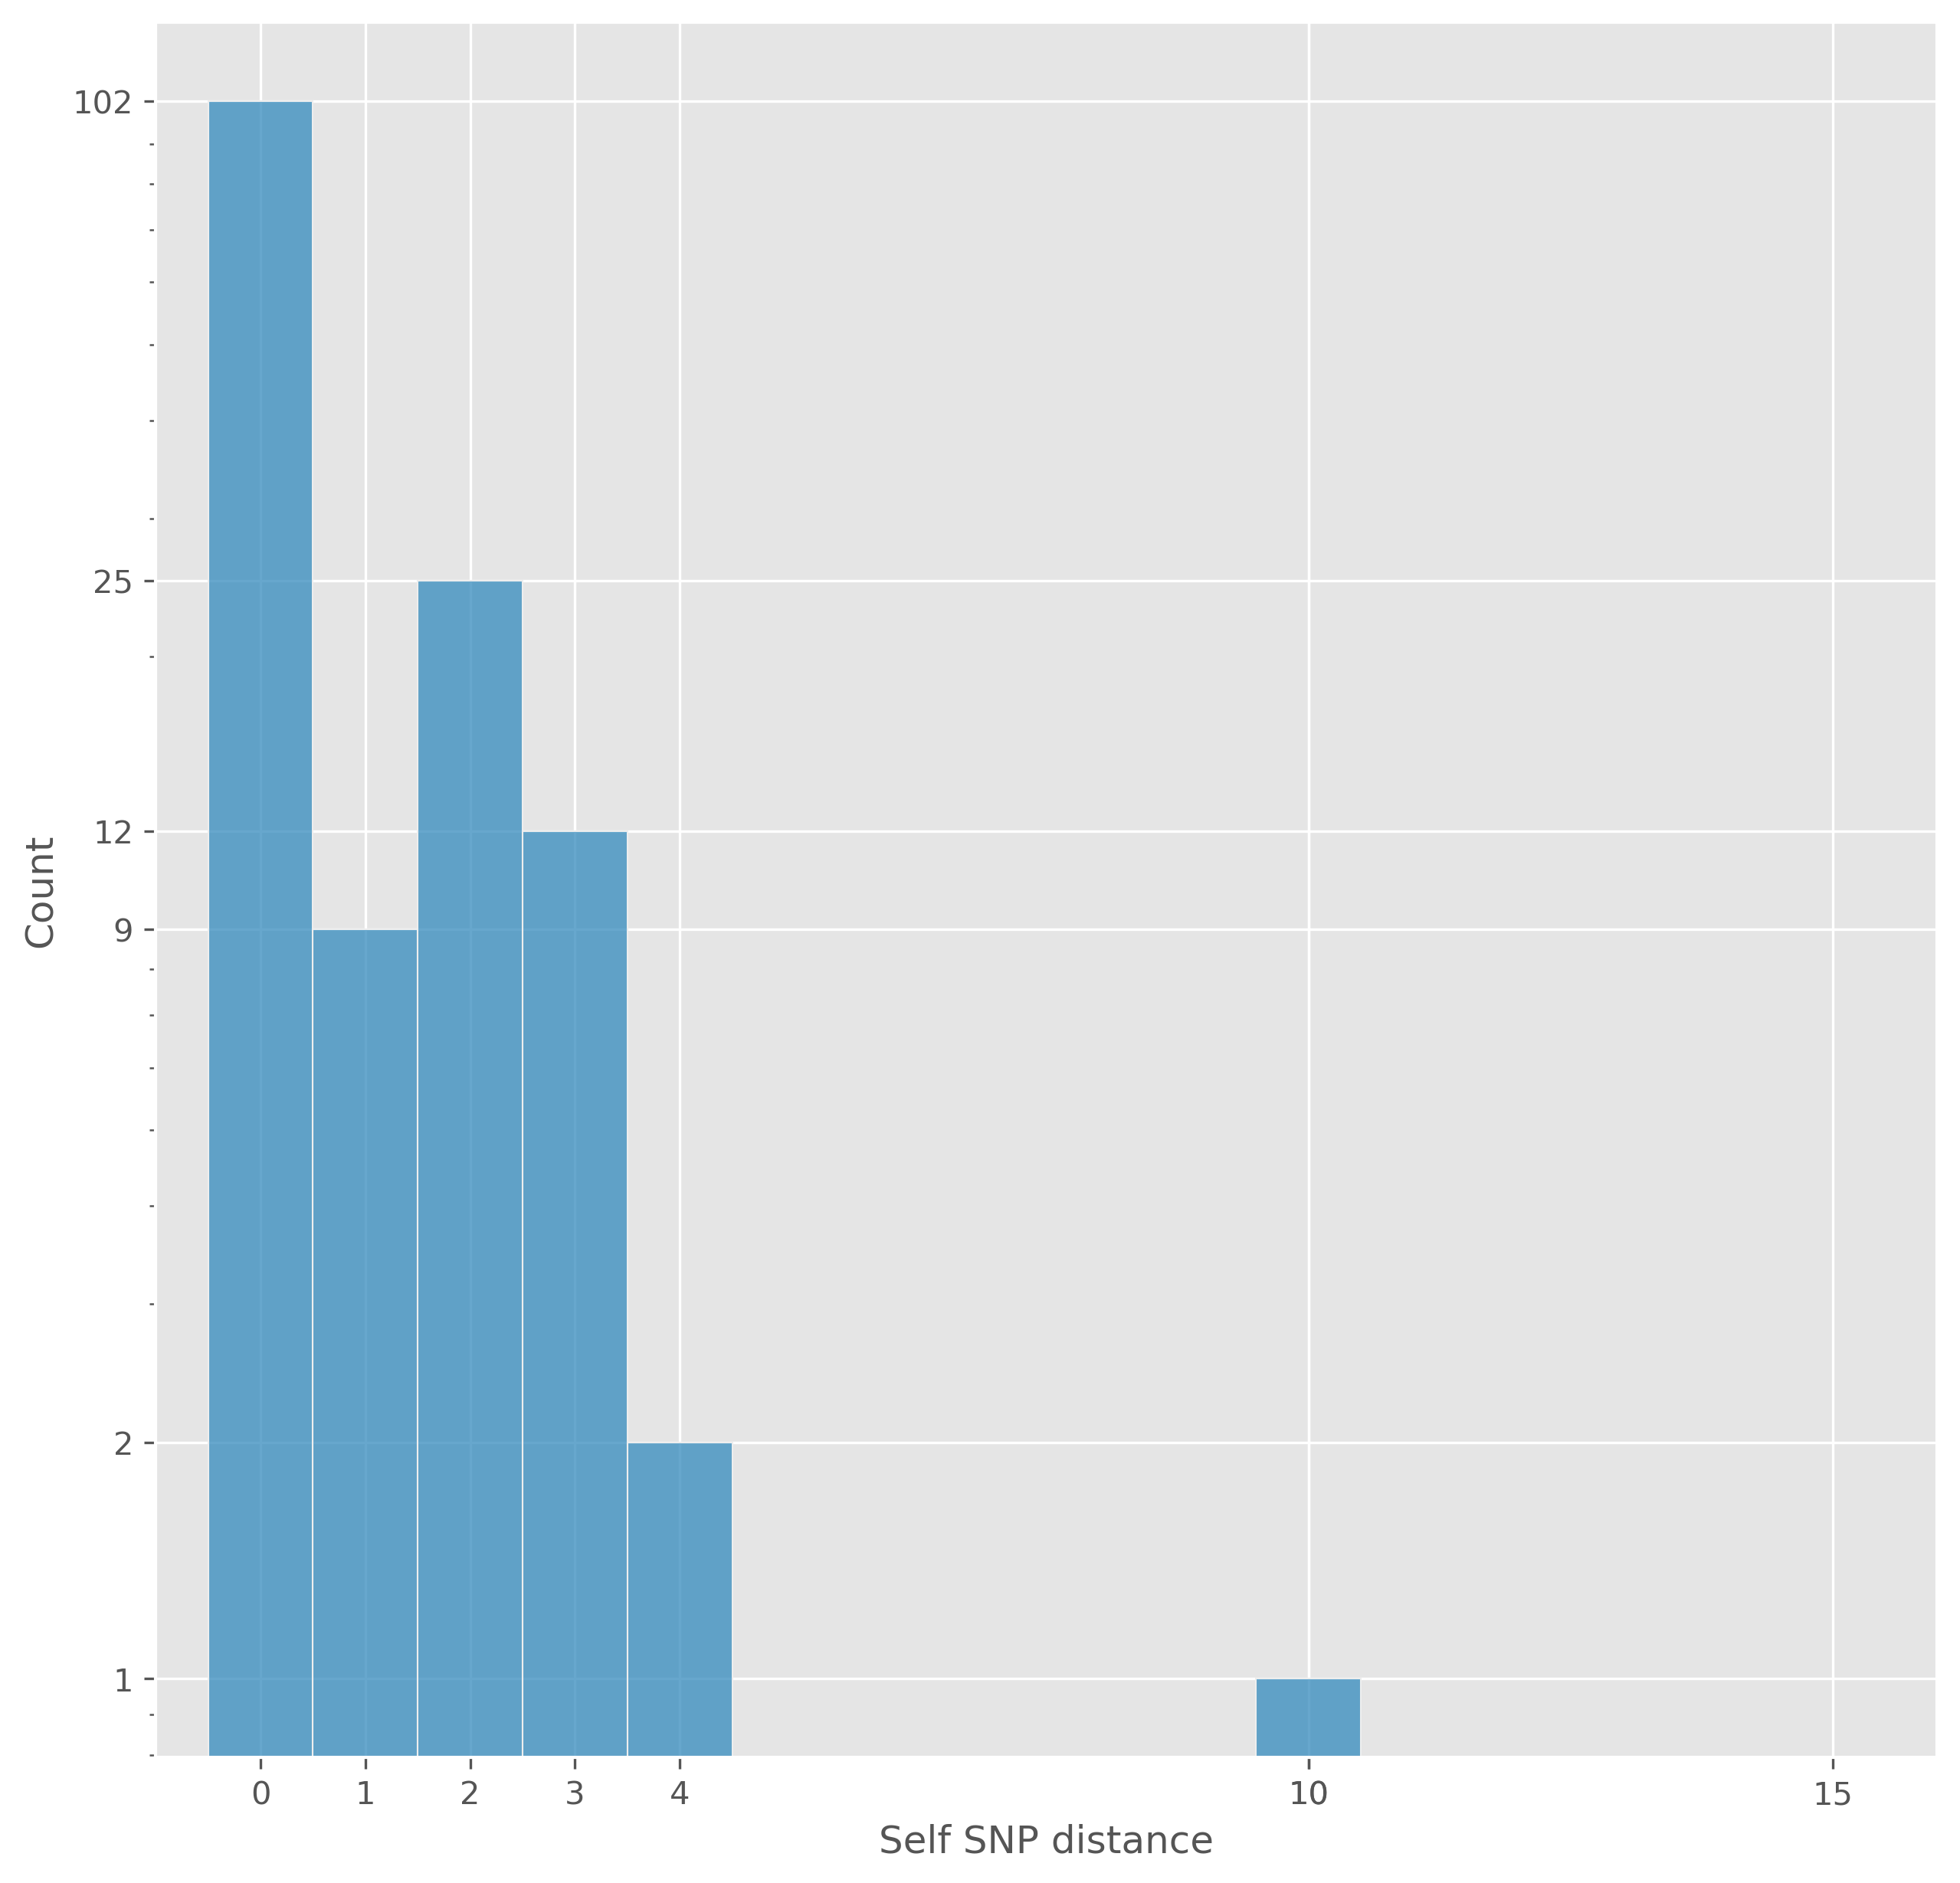

In [15]:
matrix = []
with open("mixed.matrix.csv") as instream:
    header = next(instream).rstrip()
    names = np.array(header.split(",")[1:])
    idx = np.argsort(names)
    sorted_names = names[idx]
    for row in map(str.rstrip, instream):
        # sort row according to the name sorting
        sorted_row = np.array(row.split(",")[1:], dtype=int)[idx]
        matrix.append(sorted_row)

m = np.array(matrix)[idx]
self_dists = m.diagonal()

print(pd.DataFrame(self_dists).describe())

largest_outlier = sorted_names[self_dists.argmax()]
print(
    f"Largest outlier is {largest_outlier} with a self-distance of {self_dists.max()}",
)

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
num_bins = max(self_dists) + 1
sns.histplot(self_dists, bins=num_bins, discrete=True)
ax.set_xlabel("Self SNP distance")
xticks = sorted(set(Counter(self_dists).keys()))
xticks.extend([10, 15])
xticks.sort()
ax.set_xticks(xticks)
ax.set_xlim([min(xticks)-1, max(xticks)+1])
ax.set_yscale("log")
yticks = sorted(set(Counter(self_dists).values()))
ax.set_yticks(yticks)
_ = ax.set_yticklabels(yticks)

In [16]:
for i in range(1, 10):
    numerator = sum(self_dists < i)
    print(f"{numerator/len(self_dists):.0%} ({numerator}/{len(self_dists)}) samples below {i} distance")

68% (102/151) samples below 1 distance
74% (111/151) samples below 2 distance
90% (136/151) samples below 3 distance
98% (148/151) samples below 4 distance
99% (150/151) samples below 5 distance
99% (150/151) samples below 6 distance
99% (150/151) samples below 7 distance
99% (150/151) samples below 8 distance
99% (150/151) samples below 9 distance


In [ ]:
print(pd.DataFrame(self_dists).describe().to_latex())